In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import os

sys.path.append('../tools')
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from tqdm import tqdm
import sklearn
import random

import torchvision.transforms as T
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from models.rns_dataloader import get_data

import data_utility
import annotation_utility
import interactive_plot

import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", ".*Set a lower value for log_every_n_steps if you want to see logs for the training epoch*")
warnings.filterwarnings("ignore", ".*exists and is not empty*")
warnings.filterwarnings("ignore", ".*Checkpoint directory {dirpath} exists and is not empty*")


In [3]:
data_dir = "../../../user_data/"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

In [4]:
raw_annotations = pd.read_csv(data_dir + 'full_updated_anns_annotTbl_cleaned.csv')
ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# ids = list(np.unique(raw_annotations['HUP_ID']))
ids

['HUP047',
 'HUP084',
 'HUP096',
 'HUP109',
 'HUP121',
 'HUP129',
 'HUP131',
 'HUP137',
 'HUP147',
 'HUP153',
 'HUP156',
 'HUP159',
 'HUP182',
 'HUP197',
 'HUP199',
 'HUP205',
 'RNS026',
 'RNS029']

In [5]:
data_import = data_utility.read_files(path=data_dir+'rns_data', path_data=data_dir+'rns_raw_cache', patientIDs=ids,
                                      verbose=True)  # Import data with annotation

100%|██████████| 18/18 [00:12<00:00,  1.42it/s]


In [6]:
annotations = annotation_utility.read_annotation(annotation_path=data_dir +'full_updated_anns_annotTbl_cleaned.csv',
                                                 data=data_import, n_class=3)

C:\Users\Patrick Xu\Desktop\RNS_Annotation-Pipeline\scripts\RNS_LITT_ANNOTATION_PIPELINE\rns_scripts\../tools\annotation_utility.py:138: RuntimeWarning: invalid value encountered in cast
  temp_df['Episode_Index'] = episode_ind.astype(int)
C:\Users\Patrick Xu\Desktop\RNS_Annotation-Pipeline\scripts\RNS_LITT_ANNOTATION_PIPELINE\rns_scripts\../tools\annotation_utility.py:139: RuntimeWarning: invalid value encountered in cast
  temp_df['Episode_Start_Index'] = episode_start_ind.astype(int)


In [265]:
import numpy.lib.recfunctions as rfn
np.random.seed(seed=42)
annot = annotations.annotations
annot_nonseizure = annot[annot['Class_Code'] == 0]
annot_seizure = annot[annot['Class_Code'] == 1]
patient_list = list(np.unique(annot['Patient_ID']))
# patient_list = ['RNS026', 'HUP159', 'HUP129', 'HUP096', 'HUP182']
clip_dict = {}
for p in patient_list:
    seizure_start_index = np.array([])
    seizure_end_index = np.array([])
    nonseizure_start_index = np.array([])
    nonseizure_end_index = np.array([])
    global_episode_index_seizure = np.array([])
    global_episode_index_nonseizure = np.array([])
    start_index = annot_seizure[annot_seizure['Patient_ID'] == p]['Episode_Start_Index']
    end_index = annot_seizure[annot_seizure['Patient_ID'] == p]['Episode_End_Index']
    annot_start_list = annot_seizure[annot_seizure['Patient_ID'] == p]['Annotation_Start_Index']
    annot_end_list = annot_seizure[annot_seizure['Patient_ID'] == p]['Annotation_End_Index']
    episode_index = annot_seizure[annot_seizure['Patient_ID'] == p]['Episode_Index']

    for i, slel in enumerate(zip(annot_start_list, annot_end_list, episode_index.index)):
        sl_order = np.argsort(slel[0])
        sl = np.array(slel[0])[sl_order]
        el = np.array(slel[1])[sl_order]
        ei = slel[2]

        annot_array = np.vstack((sl, el))
        seizure_start_index = np.hstack((seizure_start_index, annot_array[0, :]))
        seizure_end_index = np.hstack((seizure_end_index, annot_array[1, :]))

        nonseizure_start_index = np.hstack((nonseizure_start_index, start_index.iloc[i]))
        nonseizure_end_index = np.hstack((nonseizure_end_index, annot_array[0, 0]))

        nonseizure_start_index = np.hstack((nonseizure_start_index, annot_array[1, -1]))
        nonseizure_end_index = np.hstack((nonseizure_end_index, end_index.iloc[i]))

        if annot_array.shape[1] > 1:
            print(sl)
            print(el)
            print(annot_array[0, 1:])
            print(annot_array[1, :-1])
            print('=================')
            nonseizure_start_index = np.hstack((nonseizure_start_index,annot_array[1, :-1]))
            nonseizure_end_index = np.hstack((nonseizure_end_index,  annot_array[0, 1:]))


        global_episode_index_seizure = np.hstack((global_episode_index_seizure,
                                                  np.repeat(ei, len(seizure_start_index) -
                                                            len(global_episode_index_seizure))))
        global_episode_index_nonseizure = np.hstack((global_episode_index_nonseizure,
                                                     np.repeat(ei, len(nonseizure_start_index) -
                                                               len(global_episode_index_nonseizure))))

    assert len(global_episode_index_nonseizure) == len(nonseizure_start_index)
    assert len(global_episode_index_seizure) == len(seizure_start_index)

    start_index = annot_nonseizure[annot_nonseizure['Patient_ID'] == p]['Episode_Start_Index']
    end_index = annot_nonseizure[annot_nonseizure['Patient_ID'] == p]['Episode_End_Index']
    episode_index = start_index.index

    nonseizure_ind_arr = np.vstack(
        [nonseizure_start_index,
         nonseizure_end_index,
         global_episode_index_nonseizure]).astype(int)

    seizure_ind_arr = np.vstack(
        [seizure_start_index,
         seizure_end_index,
         global_episode_index_seizure]).astype(int)

    nonseizure_ind_arr_eps = np.vstack(
        [start_index,
         end_index,
         episode_index]).astype(int)

    nonseizure_clip_temp = np.hstack((nonseizure_ind_arr, nonseizure_ind_arr_eps))
    nonseizure_clip_label = np.zeros(nonseizure_clip_temp.shape[1]).astype(int)
    non_seizure_clip = np.vstack((nonseizure_clip_temp, nonseizure_clip_label))

    seizure_clip_temp = np.vstack(
            [seizure_start_index,
             seizure_end_index,
             global_episode_index_seizure]).astype(int)
    seizure_clip_label = np.ones(seizure_clip_temp.shape[1]).astype(int)
    seizure_clip = np.vstack((seizure_clip_temp, seizure_clip_label))

    combined_clip = np.hstack((seizure_clip, non_seizure_clip))

    valid = np.where((combined_clip[1] - combined_clip[0]) > 500)

    combined_clip = combined_clip[:,valid].squeeze()

    if combined_clip.shape[1]>0:
        # shuffled_index = np.arange(combined_clip.shape[1])
        # np.random.shuffle(shuffled_index)
        # clip_dict[p] = combined_clip[:, shuffled_index]


        structured_array = rfn.unstructured_to_structured(combined_clip.T.astype(int),
                                      np.dtype(
                                          [('start_index', 'int32'), ('end_index', 'int32'), ('episode_index', 'int32'),
                                           ('label', 'int32')]))

        clip_dict[p] = combined_clip.T[np.argsort(structured_array, order=['episode_index','start_index'])].T

np.save(data_dir + 'rns_test_cache/clip_dict.npy', clip_dict)

[7354774 7360415]
[7359648 7367427]
[7360415]
[7359648]
[45387155 45387155]
[45393904 45394079]
[45387155]
[45393904]
[10171354 10171466]
[10184056 10184074]
[10171466]
[10184056]
[9843677 9843677]
[9858793 9858804]
[9843677]
[9858793]
[56035772 56035772]
[56051340 56051320]
[56035772]
[56051340]


In [133]:
indexes = []
for key in clip_dict.keys():
    indexes.append(clip_dict[key])
indexes = np.hstack(indexes).T
unique_index = len(np.unique(indexes))

In [266]:
np.where(clip_dict['HUP159'][2] == 1280)

(array([110, 111, 112], dtype=int64),)

In [267]:
annotations.annotations

,Dataset,Annotation_Catalog_Index,Patient_ID,Alias_ID,Episode_Start_Timestamp,Episode_End_Timestamp,Episode_Start_UTC_Time,Episode_End_UTC_Time,Episode_Index,Episode_Start_Index,Episode_End_Index,Annotation_Start_Timestamp,Annotation_End_Timestamp,Annotation_Start_UTC_Time,Annotation_End_UTC_Time,Annotation_Start_Index,Annotation_End_Index,Type_Description,Class_Code,Annotation_Channel,Channel_Code,Binary_Channel_Code
0,RNS_Annotations_JimGugger,0,HUP096,RNS_1_JiGu,1427397884964000,1427397975128000,2015-03-26 19:24:44.964,2015-03-26 19:26:15.128,5,138107,160647,[],[],[],[],[],[],no,0,[],[],[]
1,RNS_Annotations_JimGugger,1,HUP096,RNS_1_JiGu,1427742903476000,1427742993628000,2015-03-30 19:15:03.476,2015-03-30 19:16:33.628,10,250781,273318,[],[],[],[],[],[],no,0,[],[],[]
2,RNS_Annotations_JimGugger,2,HUP096,RNS_1_JiGu,1427919210984000,1427919301120000,2015-04-01 20:13:30.984,2015-04-01 20:15:01.120,21,498694,521227,[],[],[],[],[],[],no,0,[],[],[]
3,RNS_Annotations_JimGugger,3,HUP096,RNS_1_JiGu,1427963083488000,1427963173624000,2015-04-02 08:24:43.488,2015-04-02 08:26:13.624,22,521228,543761,[],[],[],[],[],[],no,0,[],[],[]
4,RNS_Annotations_JimGugger,4,HUP096,RNS_1_JiGu,1428304634480000,1428304724616000,2015-04-06 07:17:14.480,2015-04-06 07:18:44.616,34,791679,814212,[],[],[],[],[],[],no,0,[],[],[]
5,RNS_Annotations_JimGugger,5,HUP096,RNS_1_JiGu,1429225687980000,1429225778116000,2015-04-16 23:08:07.980,2015-04-16 23:09:38.116,75,1594700,1617233,[1429225722598000],[1429225778116000],[2015-04-16 23:08:42.598000],[2015-04-16 23:09:38.116000],[1603354],[1617232],maybe,2,[4],[0001],[]
6,RNS_Annotations_JimGugger,6,HUP096,RNS_1_JiGu,1430787327024000,1430787417104000,2015-05-05 00:55:27.024,2015-05-05 00:56:57.104,131,2817274,2839793,[1430787366286000],[1430787387221000],[2015-05-05 00:56:06.286000],[2015-05-05 00:56:27.221000],[2827089],[2832322],yes,1,"[1,2,3,4]",[1111],[]
7,RNS_Annotations_JimGugger,7,HUP096,RNS_1_JiGu,1431039945060000,1431040035080000,2015-05-07 23:05:45.060,2015-05-07 23:07:15.080,143,3087549,3110053,[],[],[],[],[],[],no,0,[],[],[]
8,RNS_Annotations_JimGugger,8,HUP096,RNS_1_JiGu,1431240973524000,1431241063600000,2015-05-10 06:56:13.524,2015-05-10 06:57:43.600,150,3245143,3267661,[],[],[],[],[],[],no,0,[],[],[]
9,RNS_Annotations_JimGugger,9,HUP096,RNS_1_JiGu,1432248664568000,1432248754560000,2015-05-21 22:51:04.568,2015-05-21 22:52:34.560,178,3864075,3886572,[],[],[],[],[],[],no,0,[],[],[]


In [268]:
clip_dict['HUP159'][:, 110:114]

array([[10161564, 10171354, 10171466,   143618],
       [10171354, 10184056, 10184074,   166159],
       [    1280,     1280,     1280,     1317],
       [       0,        1,        1,        0]])

<IPython.core.display.Javascript object>


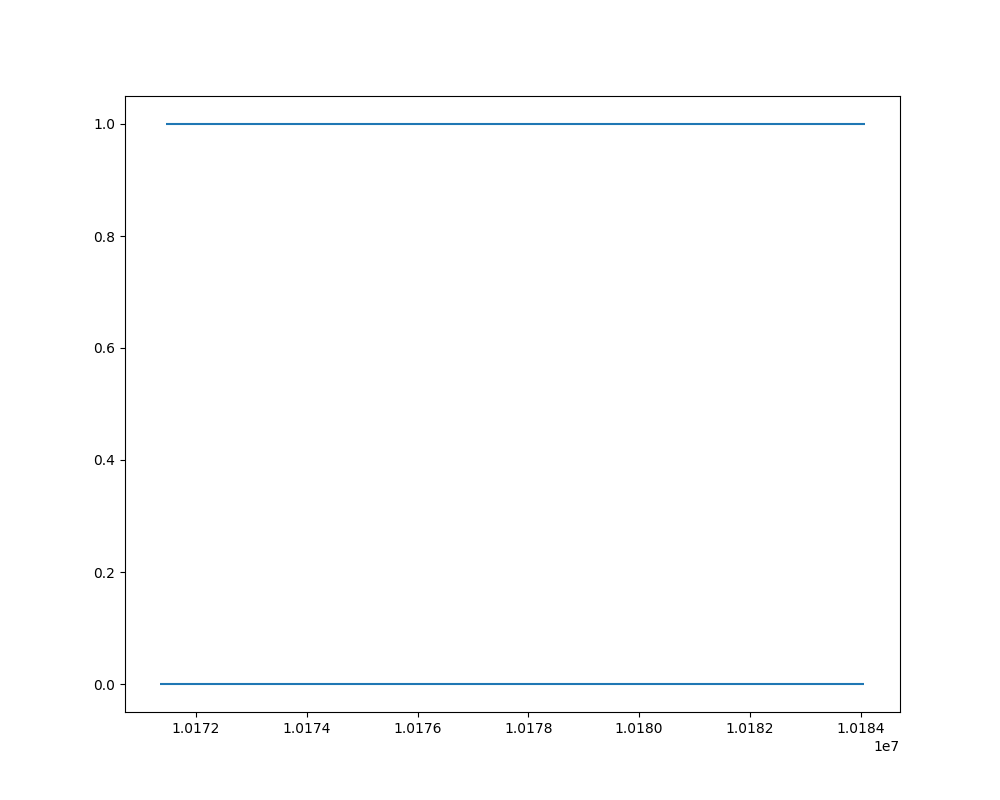

In [243]:
plt.figure(figsize=(10, 8))
plt.hlines(1,xmin=10171466,xmax=10184074)
plt.hlines(0,xmin=10171354,xmax=10184056)
plt.show()

In [177]:
for i, ind in enumerate(indexes):
    print(i)
    start_index = ind[0]
    end_index = ind[1]
    class_code = ind[3]
    slice_index = ind[2]
    # print(start_index)
    # print(end_index)
    annot = annotations.annotations[annotations.annotations.index == slice_index]
    # print(annotations.annotations[annotations.annotations.index == slice_index])
    if class_code == 0:
        try:
            assert (((start_index == annot.Episode_Start_Index) | (end_index == annot.Episode_End_Index)).item())
        except:
            print(ind)
            print(annot)

    elif class_code == 1:
        assert start_index in annot.Annotation_Start_Index.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [119]:
len(indexes)

2346

721

In [ ]:
# annot_len = {}
# for id in tqdm(clip_dict.keys()):
#     annot_len[id]=clip_dict[id].shape[1]
# annot_len

In [ ]:
# annot_len_l = []
# for id in tqdm(clip_dict.keys()):
#     annot_len_l.append(clip_dict[id].shape[1])
# annot_len_l.sort()

In [ ]:
# np.sort(annot_len_l)[::-1]

In [269]:
window_len = 1
stride = 1
concat_n = 4
for id in tqdm(clip_dict.keys()):
    data_import[id].set_window_parameter(window_length=window_len, window_displacement=stride)
    data_import[id].set_concatenation_parameter(concatenate_window_n=concat_n)
    window_indices, _ = data_import[id].get_windowed_data(clip_dict[id][0], clip_dict[id][1])
    import_indices = np.array([])
    import_label = np.array([])
    import_clip_indices = np.array([])
    import_start_indicies = np.array([])
    import_patient_ID = np.array([])
    for i, ind in enumerate(window_indices):
        import_label = np.hstack((import_label, np.repeat(clip_dict[id][3][i], len(ind))))
        import_indices = np.hstack((import_indices, np.repeat(clip_dict[id][2][i], len(ind))))
        import_clip_indices = np.hstack((import_clip_indices, np.arange(len(ind))))
        import_start_indicies = np.hstack((import_start_indicies, np.repeat(clip_dict[id][0][i], len(ind))))
        import_patient_ID = np.hstack((import_patient_ID, np.repeat(id, len(ind))))

    data_import[id].normalize_windowed_data()
    _, concatenated_data = data_import[id].get_concatenated_data(data_import[id].windowed_data, arrange='channel_stack')
    assert import_label.shape[0] == concatenated_data.shape[0]
    np.save(data_dir+'rns_test_cache/' + id + '.npy', {'data': concatenated_data, 'label': import_label, 'patientID': import_patient_ID, 'indices': np.vstack([import_indices,import_clip_indices,import_start_indicies]).T})


100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


In [ ]:
annotations.annotations.iloc[0]

In [179]:
from models.rns_dataloader import RNS_Downstream
from models.SwaV import SwaV

In [180]:
import torch
import torchvision
from torch import nn

from lightly.data import LightlyDataset, SwaVCollateFunction
from lightly.loss import SwaVLoss
from lightly.loss.memory_bank import MemoryBankModule
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes


In [181]:
def collate_fn(batch):
    info = list(zip(*batch))
    data = info[0]
    label = info[1]
    return torch.stack(data), torch.stack(label)

In [182]:
data_list = os.listdir(data_dir+'rns_test_cache')[1:]

# data_list = ['HUP182.npy',   'HUP129.npy',   'HUP109.npy', 'HUP156.npy', 'HUP096.npy', 'RNS026.npy',  'HUP159.npy']
# data_list = ['RNS026.npy', 'HUP159.npy', 'HUP129.npy', 'HUP096.npy', 'HUP182.npy']
train_data, train_label, test_data, test_label, train_index, test_index = get_data(data_list, split=0.7)
# data, label,_,_ = get_data(data_list, split=1)
# train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size=0.8, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(train_index.shape)
print(test_data.shape)
print(test_label.shape)
print(test_index.shape)


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


(75559, 249, 36)
(75559,)
(75559,)
(32389, 249, 36)
(32389,)
(32389,)


In [ ]:
from models.SupervisedDownstream import SupervisedDownstream

In [183]:
swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
model = SupervisedDownstream(swav.backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='val_loss',
                                                   filename='rns_swav_50_all_linear_eval-{epoch:02d}-{val_loss:.5f}', save_last=True, save_top_k=-1, dirpath=ckpt_folder_root + 'rns_swav_50_all_linear_eval')
csv_logger = pl_loggers.CSVLogger(log_folder_root, name='rns_swav_50_all_linear_eval')

trainer = pl.Trainer(logger=csv_logger, max_epochs=80, callbacks=[checkpoint_callback], accelerator='gpu', devices=1,precision=16)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
train_dataset = RNS_Downstream(train_data, train_label, transform=True, astensor=True)
test_dataset = RNS_Downstream(test_data, test_label, transform=False, astensor=True)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    # num_workers = 2
)

val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

trainer.fit(model, train_dataloader, val_dataloader)

In [184]:
test_dataset = RNS_Downstream(test_data, test_label, transform=False, astensor=True)
val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

data loaded
(32389, 249, 36)
(32389,)


In [ ]:
data_list = os.listdir(data_dir+'rns_test_cache')[1:]
# data_list = ['RNS026_seizure.npy', 'HUP159_seizure.npy', 'HUP129_seizure.npy', 'HUP096_seizure.npy','RNS026_nonseizure.npy', 'HUP159_nonseizure.npy', 'HUP129_nonseizure.npy', 'HUP096_nonseizure.npy']
class RNS_Downstream(Dataset):
    def __init__(self, file_names, transform=True, astensor=True):
        self.file_names = file_names
        self.transform = transform

        file_name_temp = self.file_names[0]
        cache = np.load(data_dir +'rns_test_cache/' + file_name_temp, allow_pickle=True)
        temp_file = cache.item().get('data')

        self.data = np.empty((0, temp_file.shape[1], temp_file.shape[2]))
        self.label = np.array([])
        print(self.data.shape)

        for name in tqdm(self.file_names):
            cache = np.load(data_dir +'rns_test_cache/' + name, allow_pickle=True)
            data = cache.item().get('data')
            label = cache.item().get('label')
            self.data = np.vstack((self.data, data))
            self.label = np.hstack((self.label, label))

        print('data loaded')

        self.label = self.label[np.newaxis].T

        self.length = len(self.data)

        if astensor:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
                T.ToTensor()
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.ToTensor()
            ])
        else:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
            ])


    def __len__(self):
        return self.length


    def __getitem__(self, index):
        data = self.data[index]
        label = self.label[index]

        if self.transform:
            concat_len = data.shape[1] / 4
            channel_index = np.arange(4)
            np.random.shuffle(channel_index)
            channel_index = channel_index * concat_len + (concat_len - 1) / 2
            channel_index = np.repeat(channel_index, concat_len)
            concate_len_1 = (concat_len - 1) / 2
            a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
            base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
            channel_index = channel_index + base_repeat
            data = data[channel_index.astype(int)]
            data = torch.from_numpy(data).clone()
            data = data.repeat(3, 1, 1)
            data = self.augmentation(data)

        else:
            concat_len = data.shape[1] / 4
            channel_index = np.arange(4)
            # np.random.shuffle(channel_index)
            channel_index = channel_index * concat_len + (concat_len - 1) / 2
            channel_index = np.repeat(channel_index, concat_len)
            concate_len_1 = (concat_len - 1) / 2
            a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
            base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
            channel_index = channel_index + base_repeat
            data = data[channel_index.astype(int)]
            data = torch.from_numpy(data).clone()
            data = data.repeat(3, 1, 1)
            data = self.totensor(data)

        return data, torch.from_numpy(label).to(dtype=torch.long), None

dataset = RNS_Downstream(data_list, transform=False,astensor = True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

In [185]:
predictions = trainer.predict(model,val_dataloader,ckpt_path=ckpt_folder_root + 'rns_swav_50_all_linear_eval/rns_swav_50_all_linear_eval-epoch=06-val_loss=1.52025.ckpt')

Restoring states from the checkpoint path at ../../../user_data/checkpoints/rns_swav_50_all_linear_eval/rns_swav_50_all_linear_eval-epoch=06-val_loss=1.52025.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../../../user_data/checkpoints/rns_swav_50_all_linear_eval/rns_swav_50_all_linear_eval-epoch=06-val_loss=1.52025.ckpt


Predicting: 0it [00:00, ?it/s]

In [186]:
output_list = []
target_list = []
emb_list = []
m = nn.Softmax(dim=1)
for pred, y, emb in predictions:
    output_list.append(pred)
    target_list.append(y)
    emb_list.append(emb)

In [187]:
pred_raw = torch.vstack(output_list)
target = torch.vstack(target_list)
emb = torch.vstack(emb_list)
out = torch.argmax(pred_raw, dim=1)

In [188]:
m(pred_raw.float())[:,0]

tensor([1.0000, 0.9982, 0.9950,  ..., 1.0000, 1.0000, 1.0000])

In [211]:
len(list(np.unique(test_index)))

32213

In [213]:
index_list = []
for i in range(len(list(np.unique(test_index['episode_index'])))):

    print(i)

    index_location = np.where(test_index['episode_index'] == list(np.unique(test_index['episode_index']))[i])[0]

    # print(target[index_location[np.argsort(test_index[index_location], order=['start_index','slice_index'])]].squeeze(1))
    # print(out[index_location[np.argsort(test_index[index_location], order=['start_index','slice_index'])]])
    index_array = test_index[index_location[np.argsort(test_index[index_location], order=['start_index','slice_index'])]]
    start_ind = np.unique(index_array['start_index'])

    annot = annotations.annotations[annotations.annotations.index == np.unique(index_array['episode_index'])[0]]

    start_indexes = []
    start_indexes.extend(annot.Annotation_Start_Index.item())
    start_indexes.extend(annot.Annotation_End_Index.item())
    start_indexes.append(annot.Episode_Start_Index.item())
    start_indexes.append(annot.Episode_End_Index.item())
    # print(start_indexes)

    in_list = []
    for si in start_ind:
        in_list.append(si in start_indexes)

    assert True in in_list

# [annot.Annotation_Start_Index.item(), annot.Episode_Start_Index, ]

    # # print(annotations.annotations[annotations.annotations.index == slice_index])
    # if class_code == 0:
    #     try:
    #         assert (((start_index == annot.Episode_Start_Index) | (end_index == annot.Episode_End_Index)).item())
    #     except:
    #         print(ind)
    #         print(annot)
    #
    # elif class_code == 1:
    #     assert start_index in annot.Annotation_Start_Index.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [214]:
sklearn.metrics.accuracy_score(torch.argmax(pred_raw, dim=1), target)

0.9499212695668282

In [215]:
clf_report = sklearn.metrics.classification_report(torch.argmax(pred_raw, dim=1), target, digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.981276  0.947581  0.964134     23007
           1   0.881439  0.955660  0.917050      9382

    accuracy                       0.949921     32389
   macro avg   0.931357  0.951620  0.940592     32389
weighted avg   0.952356  0.949921  0.950495     32389



In [216]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [217]:
len(emb)

32389

In [32]:
pca_comp_n = 30
batch_size = 32

pca = PCA(n_components=pca_comp_n, copy=True).fit(emb)
p = pca.transform(emb)

# ind = np.random.choice(len(emb), 10000)
#
tsne = TSNE(n_components=2, verbose=1, perplexity=75, random_state=142, init='pca')
z = tsne.fit_transform(emb)
interictal_inds = np.where(target == 0)[0]
ictal_inds = np.where(target == 1)[0]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 32389 samples in 0.031s...



KeyboardInterrupt



In [ ]:
pca.explained_variance_ratio_

In [ ]:
len(interictal_inds)

In [ ]:
len(ictal_inds)

In [ ]:
# spc = p
#
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(spc[interictal_inds,0],spc[interictal_inds,1],spc[interictal_inds,2],c='gold',label= 'interictal')
# ax.scatter(spc[ictal_inds, 0], spc[ictal_inds, 1],spc[ictal_inds, 2], c='royalblue', label='ictal')
# # plt.title('Swav Embedding t-SNE')
# ax.set_xlabel('comp 1')
# ax.set_ylabel("comp 2")
# ax.set_zlabel("comp 2")
# plt.legend()
# # plt.xlim(-67, 74)
# # plt.ylim(-67, 75)
# plt.grid()
# # plt.show()

In [ ]:
spc = p
plt.figure(figsize=(10, 8))
plt.scatter(spc[interictal_inds,0],spc[interictal_inds,1],c='gold',label= 'interictal')
plt.scatter(spc[ictal_inds, 0], spc[ictal_inds, 1], c='royalblue', label='ictal',s=0.5)
# plt.title('Swav Embedding t-SNE')
plt.xlabel('comp 1')
plt.ylabel("comp 2")
plt.legend()
# plt.xlim(-67, 74)
# plt.ylim(-67, 75)
plt.grid()
plt.show()

In [ ]:
# dt = np.vstack((z[:,0], z[:,1])).T
interactive_plot.interactive_plot(z, ['RNS026', 'HUP159', 'HUP129', 'HUP096'], data_import, color_override=target)

In [ ]:
interactive_plot.interactive_plot(z, ['HUP159'], data_import, color_override=target)

In [ ]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(m(pred_raw.float()), target, pos_label=1)
sklearn.metrics.auc(fpr, tpr)

In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(
    target,
    m(pred_raw.float())[:,1],
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.hlines(y = 1, xmin = 0, xmax = 1)
plt.vlines(x = 0, ymin = 0, ymax = 1)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
PrecisionRecallDisplay.from_predictions(
    target,
    m(pred_raw.float())[:,1],
    color="darkorange",
)
# plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(target,
    m(pred_raw.float())[:,1])
metrics.auc(fpr, tpr)

In [ ]:
output[:, 1]

In [ ]:

output = torch.argmax(output, dim=1)
output = output.detach().cpu().numpy()
target = target.squeeze().detach().cpu().numpy()

In [ ]:
import sklearn

clf_report = sklearn.metrics.classification_report(output, target, digits=6)

print(f"Classification Report : \n{clf_report}")

In [ ]:
for batch, label in tqdm(val_dataloader):
    batch = batch.to(device)
    label = label.to(device)
    label = F.one_hot(label).squeeze()
    outputs = model(batch)
    print(batch)
    loss = sigmoid_focal_loss(pred.float(), label.float(), alpha=0.5, gamma=8, reduction='mean')
    print(loss)
    break

In [ ]:
# import copy
# import torch
# import torchvision
# from torch import nn
#
# from lightly.data import DINOCollateFunction, LightlyDataset
# from lightly.loss import DINOLoss
# from lightly.models.modules import DINOProjectionHead
# from lightly.models.utils import deactivate_requires_grad, update_momentum
# from lightly.utils.scheduler import cosine_schedule
#
#
# class DINO(torch.nn.Module):
#     def __init__(self, backbone, input_dim):
#         super().__init__()
#         self.student_backbone = backbone
#         self.student_head = DINOProjectionHead(
#             input_dim, 512, 64, 2048, freeze_last_layer=1
#         )
#         self.teacher_backbone = copy.deepcopy(backbone)
#         self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
#         deactivate_requires_grad(self.teacher_backbone)
#         deactivate_requires_grad(self.teacher_head)
#
#     def forward(self, x):
#         y = self.student_backbone(x).flatten(start_dim=1)
#         z = self.student_head(y)
#         return z
#
#     def forward_teacher(self, x):
#         y = self.teacher_backbone(x).flatten(start_dim=1)
#         z = self.teacher_head(y)
#         return z
#
#
# resnet = torchvision.models.resnet18()
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# input_dim = 512
# # instead of a resnet you can also use a vision transformer backbone as in the
# # original paper (you might have to reduce the batch size in this case):
# # backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
# # input_dim = backbone.embed_dim
#
# model = DINO(backbone, input_dim)
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
#
# # # we ignore object detection annotations by setting target_transform to return 0
# # pascal_voc = torchvision.datasets.VOCDetection(
# #     "datasets/pascal_voc", download=True, target_transform=lambda t: 0
# # )
# # dataset = LightlyDataset.from_torch_dataset(pascal_voc)
# # # or create a dataset from a folder containing images or videos:
# # # dataset = LightlyDataset("path/to/folder")
#
# collate_fn = DINOCollateFunction(solarization_prob = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0)
#
# dataloader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=64,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
#     num_workers=1,
# )
#
# criterion = DINOLoss(
#     output_dim=2048,
#     warmup_teacher_temp_epochs=5,
# )
# # move loss to correct device because it also contains parameters
# criterion = criterion.to(device)
#
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
# epochs = 10
#
# print("Starting Training")
# for epoch in range(epochs):
#     total_loss = 0
#     momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
#     for views, _, _ in tqdm(dataloader):
#         update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
#         update_momentum(model.student_head, model.teacher_head, m=momentum_val)
#         views = [view.to(device) for view in views]
#         global_views = views[:2]
#         teacher_out = [model.forward_teacher(view) for view in global_views]
#         student_out = [model.forward(view) for view in views]
#         loss = criterion(teacher_out, student_out, epoch=epoch)
#         total_loss += loss.detach()
#         loss.backward()
#         # We only cancel gradients of student head.
#         model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [ ]:
augmentation = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 512), interpolation=T.InterpolationMode.NEAREST),
    T.RandomApply([T.ColorJitter()], p=0.5),
    T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
    T.RandomInvert(p=0.2),
    T.RandomPosterize(4, p=0.2),
])

data = ictal_data_X[0]

channel_index = np.arange(data.shape[0])
np.random.shuffle(channel_index)
data = data[channel_index]
data = torch.from_numpy(data).clone()
data = data.repeat(3, 1, 1)
data = augmentation(data)
data

In [ ]:
channel_index

In [ ]:
data[channel_index]

In [ ]:
data

In [ ]:
#
# print("Starting Training")
# for epoch in range(50):
#     total_loss = 0
#     i = 0
#     for batch, label in tqdm(dataloader):
#         batch = batch.to(device)
#         # print(type(batch))
#         label = label.to(device)
#         label = F.one_hot(label).squeeze()
#         outputs = model(batch)
#         loss = sigmoid_focal_loss(outputs.float(),label.float(), alpha = 0.25, gamma = 7,reduction = 'mean')
#         total_loss += loss.detach()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             }, 'ckpt/checkpoint'+str(epoch)+'.pth')
#
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")